# Fit the poly-spline-warmpix acquisition probability model in 2018-04

**THIS NOTEBOOK IS FOR REFERENCE ONLY**

This is an attempt to fit the flight acquisition data using the `poly-spline-warmpix` model.
This uses starting fit values from the accompanying `fit_acq_prob_model-2018-04-binned-poly-warmpix.ipynb` notebook.

This model is a 15-parameter fit for acquisition probability as a function of magnitude and warm pixel fraction.  It is NOT USED in flight because the mag/T_ccd parametrization gives a better fit.

In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
import tables
from scipy import stats
import tables3_api
from scipy.interpolate import CubicSpline

%matplotlib inline

## Get acq stats data and clean

In [2]:
with tables.open_file('/proj/sot/ska/data/acq_stats/acq_stats.h5', 'r') as h5:
    cols = h5.root.data.cols
    names = {'tstart': 'guide_tstart',
             'obsid': 'obsid',
             'obc_id': 'acqid',
             'halfwidth': 'halfw',
             'warm_pix': 'n100_warm_frac',
             'mag_aca': 'mag_aca',
             'mag_obs': 'mean_trak_mag',
             'known_bad': 'known_bad',
             'color': 'color1',
            'img_func': 'img_func', 
            'ion_rad': 'ion_rad',
            'sat_pix': 'sat_pix',
             'agasc_id': 'agasc_id',
             't_ccd': 'ccd_temp',
            'slot': 'slot'}
    acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                 names=list(names.keys()))

    year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately

In [3]:
acqs['year'] = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
acqs['quarter'] = (np.trunc((acqs['year'] - year_q0) * 4)).astype('f4')
acqs['color_1p5'] = np.where(acqs['color'] == 1.5, 1, 0)

In [4]:
# Create 'fail' column, rewriting history as if the OBC always
# ignore the MS flag in ID'ing acq stars.  Set ms_disabled = False
# to not do this
obc_id = acqs['obc_id']
obc_id_no_ms = (acqs['img_func'] == 'star') & ~acqs['sat_pix'] & ~acqs['ion_rad']
acqs['fail'] = np.where(obc_id | obc_id_no_ms, 0.0, 1.0)
acqs['fail_mask'] = acqs['fail'].astype(bool)

In [5]:
# Define a 'mag' column that is the observed mag if available else the catalog mag
USE_OBSERVED_MAG = False
if USE_OBSERVED_MAG:
    acqs['mag'] = np.where(acqs['fail_mask'], acqs['mag_aca'], acqs['mag_obs'])
else:
    acqs['mag'] = acqs['mag_aca']

In [6]:
# Filter for year and mag (previously used data through 2007:001)
ok = (acqs['year'] > 2014.0) & (acqs['mag'] > 8.5) & (acqs['mag'] < 10.6)

In [7]:
# Filter known bad obsids
print('Filtering known bad obsids, start len = {}'.format(np.count_nonzero(ok)))
bad_obsids = [
    # Venus
    2411,2414,6395,7306,7307,7308,7309,7311,7312,7313,7314,7315,7317,7318,7406,583,
    7310,9741,9742,9743,9744,9745,9746,9747,9749,9752,9753,9748,7316,15292,16499,
    16500,16501,16503,16504,16505,16506,16502,
    ]
for badid in bad_obsids:
    ok = ok & (acqs['obsid'] != badid)
print('Filtering known bad obsids, end len = {}'.format(np.count_nonzero(ok)))

Filtering known bad obsids, start len = 40753
Filtering known bad obsids, end len = 40753


In [8]:
data_all = acqs[ok]
del data_all['img_func']
data_all.sort('year')

In [9]:
# Adjust probability (in probit space) for box size.  See:
# https://github.com/sot/skanb/blob/master/pea-test-set/fit_box_size_acq_prob.ipynb
b1 = 0.96
b2 = -0.30
box0 = (data_all['halfwidth'] - 120) / 120  # normalized version of box, equal to 0.0 at nominal default
data_all['box_delta'] = b1 * box0 + b2 * box0**2

In [10]:
data_all = data_all.group_by('quarter')
data_mean = data_all.groups.aggregate(np.mean)

## Model definition

In [11]:
spline_mags = np.array([8.5, 9.25, 10.0, 10.4, 10.6])

def p_fail(pars, mag,
           wp, wp2=None,
           box_delta=0):
    """
    Acquisition probability model

    :param pars: 7 parameters (3 x offset, 3 x scale, p_fail for bright stars)
    :param wp: warm fraction
    :param box_delta: search box half width (arcsec)
    """
    p_bright_fail = 0.03  # For now

    p0s, p1s, p2s = pars[0:5], pars[5:10], pars[10:15]
    
    if wp2 is None:
        wp2 = wp ** 2
    
    # Make sure box_delta has right dimensions
    wp, box_delta = np.broadcast_arrays(wp, box_delta)

    p0 = CubicSpline(spline_mags, p0s, bc_type=((1, 0.0), (2, 0.0)))(mag)
    p1 = CubicSpline(spline_mags, p1s, bc_type=((1, 0.0), (2, 0.0)))(mag)
    p2 = CubicSpline(spline_mags, p2s, bc_type=((1, 0.0), (2, 0.0)))(mag)
    
    probit_p_fail = p0 + p1 * wp + p2 * wp2 + box_delta
    p_fail = stats.norm.cdf(probit_p_fail)  # transform from probit to linear probability

    return p_fail

def p_acq_fail(data=None):
    """
    Sherpa fit function wrapper to ensure proper use of data in fitting.
    """
    if data is None:
        data = data_all
        
    wp = (data['warm_pix'] - 0.13) / 0.1
    wp2 = wp ** 2
    box_delta = data['box_delta']
    mag = data['mag']
    
    def sherpa_func(pars, x=None):
        return p_fail(pars, mag, wp, wp2, box_delta)

    return sherpa_func

In [12]:
def fit_poly_spline_model(data_mask=None):
    from sherpa import ui

    data = data_all if data_mask is None else data_all[data_mask]

    comp_names = [f'p{i}{j}' for i in range(3) for j in range(5)]
    
    # Approx starting values based on plot of p0, p1, p2 in
    # fit_acq_prob_model-2018-04-poly-warmpix
    spline_p = {}
    spline_p[0] = np.array([-2.6, -2.3, -1.7, -1.0, 0.0])
    spline_p[1] = np.array([0.1, 0.1, 0.3, 0.6, 2.4])
    spline_p[2] = np.array([0.0, 0.1, 0.5, 0.4, 0.1])
    
    data_id = 1
    ui.set_method('simplex')
    ui.set_stat('cash')
    ui.load_user_model(p_acq_fail(data), 'model')
    ui.add_user_pars('model', comp_names)
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data['year']), np.array(data['fail'], dtype=np.float))

    # Initial fit values from fit of all data
    fmod = ui.get_model_component('model')
    for i in range(3):
        for j in range(5):
            comp_name = f'p{i}{j}'
            setattr(fmod, comp_name, spline_p[i][j])
            comp = getattr(fmod, comp_name)
            comp.max = 10
            comp.min = -4.0 if i == 0 else 0.0
            
    ui.fit(data_id)
    # conf = ui.get_confidence_results()
    return ui.get_fit_results()

## Plotting and validation

In [13]:
def plot_fit_grouped(pars, group_col, group_bin, mask=None, log=False, colors='br', label=None, probit=False):
    data = data_all if mask is None else data_all[mask]
    data['model'] = p_acq_fail(data)(pars)

    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    data_fail = data_mean['fail']
    model_fail = np.array(data_mean['model'])
    
    fail_sigmas = np.sqrt(data_fail * len_groups) / len_groups
    
    # Possibly plot the data and model probabilities in probit space
    if probit:
        dp = stats.norm.ppf(np.clip(data_fail + fail_sigmas, 1e-6, 1-1e-6))
        dm = stats.norm.ppf(np.clip(data_fail - fail_sigmas, 1e-6, 1-1e-6))
        data_fail = stats.norm.ppf(data_fail)
        model_fail = stats.norm.ppf(model_fail)
        fail_sigmas = np.vstack([data_fail - dm, dp - data_fail])
            
    plt.errorbar(data_mean[group_col], data_fail, yerr=fail_sigmas, 
                 fmt='.' + colors[1:], label=label, markersize=8)
    plt.plot(data_mean[group_col], model_fail, '-' + colors[0])
    
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [14]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag'] > mag0) & (data_all['mag'] < mag1)
    return ok

In [15]:
def t_ccd_filter(t_ccd0, t_ccd1):
    ok = (data_all['t_ccd'] > t_ccd0) & (data_all['t_ccd'] < t_ccd1)
    return ok

In [16]:
def wp_filter(wp0, wp1):
    ok = (data_all['warm_pix'] > wp0) & (data_all['warm_pix'] < wp1)
    return ok

In [17]:
def plot_fit_all(parvals, mask=None, probit=False):
    if mask is None:
        mask = np.ones(len(data_all), dtype=bool)
    
    plt.figure()
    plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.20, 0.25) & mask, log=False, 
                     colors='gk', label='0.20 < WP < 0.25')
    plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.10, 0.20) & mask, log=False, 
                     colors='cm', label='0.10 < WP < 0.20')
    plt.legend(loc='upper left');
    plt.ylim(0.001, 1.0);
    plt.xlim(9, 11)
    plt.grid()
    
    plt.figure()
    plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.20, 0.25) & mask, probit=True, colors='gk', label='0.20 < WP < 0.25')
    plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.10, 0.20) & mask, probit=True, colors='cm', label='0.10 < WP < 0.20')
    plt.legend(loc='upper left');
    # plt.ylim(0.001, 1.0);
    plt.xlim(9, 11)
    plt.grid()
    
    plt.figure()
    plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(10.3, 10.6) & mask, log=False, colors='gk', label='10.3 < mag < 10.6')
    plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(10, 10.3) & mask, log=False, colors='cm', label='10 < mag < 10.3')
    plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(9, 10) & mask, log=False, colors='br', label='9 < mag < 10')
    plt.legend(loc='best')
    plt.grid()
    
    plt.figure()
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10.3, 10.6) & mask,  colors='gk', label='10.3 < mag < 10.6')
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10, 10.3) & mask, colors='cm', label='10 < mag < 10.3')
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.5, 10) & mask, colors='br', label='9.5 < mag < 10')
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 9.5) & mask,  colors='gk', label='9.0 < mag < 9.5')
    plt.legend(loc='best')
    plt.grid()
    
    plt.figure()
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10.3, 10.6) & mask,  colors='gk', label='10.3 < mag < 10.6', probit=True)
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10, 10.3) & mask, colors='cm', label='10 < mag < 10.3', probit=True)
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.5, 10) & mask, colors='br', label='9.5 < mag < 10', probit=True)
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 9.5) & mask,  colors='gk', label='9.0 < mag < 9.5', probit=True)
    plt.legend(loc='best')
    plt.grid();

In [18]:
def plot_splines(pars):
    mag = np.arange(8.5, 10.81, 0.1)
    p0 = CubicSpline(spline_mags, pars[0:5], bc_type=((1, 0.0), (2, 0.0)))(mag)
    p1 = CubicSpline(spline_mags, pars[5:10], bc_type=((1, 0.0), (2, 0.0)))(mag)
    p2 = CubicSpline(spline_mags, pars[10:15], bc_type=((1, 0.0), (2, 0.0)))(mag)
    plt.plot(mag, p0, label='p0')
    plt.plot(mag, p1, label='p1')
    plt.plot(mag, p2, label='p2')
    plt.grid()
    plt.legend();


### Color != 1.5 fit (this is MOST acq stars)

In [19]:
# fit = fit_sota_model(data_all['color'] == 1.5, ms_disabled=True)
mask_no_1p5 = data_all['color'] != 1.5

In [20]:
fit_no_1p5 = fit_poly_spline_model(mask_no_1p5)

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 10317.3
Final fit statistic   = 9845.9 at function evaluation 7114
Data points           = 34286
Degrees of freedom    = 34271
Change in statistic   = 471.353
   model.p00      -2.68804    
   model.p01      -2.54594    
   model.p02      -1.70204    
   model.p03      -1.30518    
   model.p04      -1.01774    
   model.p10      2.71277e-07 
   model.p11      0.490068    
   model.p12      0.165871    
   model.p13      1.09107e-08 
   model.p14      1.12473     
   model.p20      0.0294016   
   model.p21      1.05548e-07 
   model.p22      0.246156    
   model.p23      0.870964    
   model.p24      0.103713    


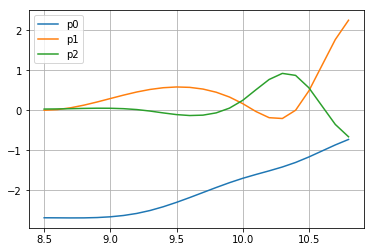

In [21]:
plot_splines(fit_no_1p5.parvals)

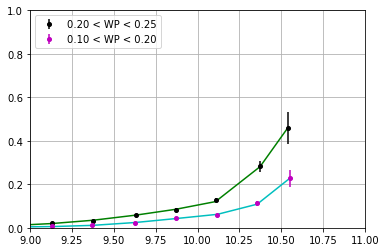

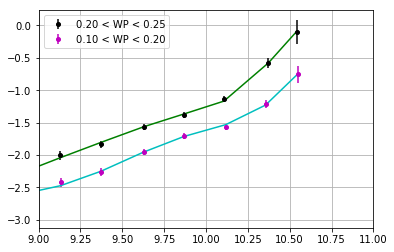

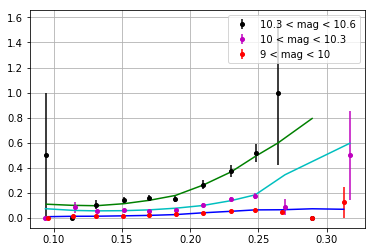

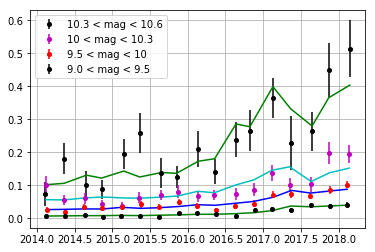

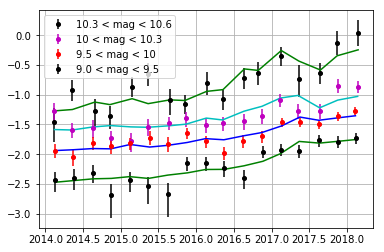

In [22]:
plot_fit_all(fit_no_1p5.parvals, mask_no_1p5)

NameError: name 'DateTime' is not defined

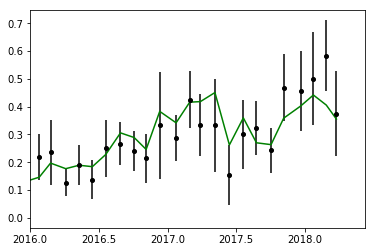

In [23]:
plot_fit_grouped(fit_no_1p5.parvals, 'year', 0.10, mag_filter(10.3, 10.6) & mask_no_1p5,  
                 colors='gk', label='10.3 < mag < 10.6')
plt.xlim(2016.0, None)
y0, y1 = plt.ylim()
x = DateTime('2017-10-01T00:00:00').frac_year
plt.plot([x, x], [y0, y1], '--r', alpha=0.5)
plt.grid();

In [ ]:
plot_fit_grouped(fit_no_1p5.parvals, 'year', 0.10, mag_filter(10.0, 10.3) & mask_no_1p5,  
                 colors='gk', label='10.0 < mag < 10.3')
plt.xlim(2016.0, None)
y0, y1 = plt.ylim()
x = DateTime('2017-10-01T00:00:00').frac_year
plt.plot([x, x], [y0, y1], '--r', alpha=0.5)
plt.grid();

###  Comparing warm_pix vs. T_ccd parametrization

Looking at the next four plots, it seems that `T_ccd` provides more separation than `warm_pix`.

In [ ]:
dat = data_all
ok = (dat['year'] > 2017.75) & (mask_no_1p5) & (dat['mag_aca'] > 10.3) & (dat['mag_aca'] < 10.6)
dok = dat[ok]
plt.hist(dok['t_ccd'], bins=np.arange(-15, -9, 0.4));
plt.grid();

In [ ]:
dat = data_all
ok = (dat['year'] < 2017.75) & (dat['year'] > 2017.0) & (mask_no_1p5) & (dat['mag_aca'] > 10.3) & (dat['mag_aca'] < 10.6)
dok = dat[ok]
plt.hist(dok['t_ccd'], bins=np.arange(-15, -9, 0.4));
plt.grid()

In [ ]:
dat = data_all
ok = (dat['year'] > 2017.75) & (mask_no_1p5) & (dat['mag_aca'] > 10.3) & (dat['mag_aca'] < 10.6)
dok = dat[ok]
plt.hist(dok['warm_pix'], bins=np.linspace(0.15, 0.30, 30));
plt.grid()

In [ ]:
dat = data_all
ok = (dat['year'] < 2017.75) & (dat['year'] > 2017.0) & (mask_no_1p5) & (dat['mag_aca'] > 10.3) & (dat['mag_aca'] < 10.6)
dok = dat[ok]
plt.hist(dok['warm_pix'], bins=np.linspace(0.15, 0.30, 30));
plt.grid()

### Looking to see if repeat observations of particular stars impact the results

Probably not.

In [ ]:
np.count_nonzero(ok)

In [ ]:
from collections import defaultdict
fails = defaultdict(list)
for row in dok:
    fails[row['agasc_id']].append(row['fail'])

In [ ]:
fails

In [ ]:
np.count_nonzero(dat['fail_mask'][ok])

In [ ]:
dok = dat[ok]

### Histogram of warm pixel fraction

In [ ]:
plt.hist(data_all['warm_pix'], bins=100)
plt.grid()
plt.xlabel('Warm pixel fraction');

In [ ]:
plt.hist(data_all['mag'], bins=np.arange(6, 11.1, 0.1))
plt.grid()
plt.xlabel('Mag_aca')

In [ ]:
ok = ~data_all['fail'].astype(bool)
dok = data_all[ok]
plt.plot(dok['mag_aca'], dok['mag_obs'] - dok['mag_aca'], '.')
plt.plot(dok['mag_aca'], dok['mag_obs'] - dok['mag_aca'], ',', alpha=0.3)
plt.grid()

In [ ]:
plt.plot(data_all['year'], data_all['warm_pix'])
plt.ylim(0, None)
plt.grid();

In [ ]:
plt.plot(data_all['year'], data_all['t_ccd'])
# plt.ylim(0, None)
plt.xlim(2017.0, None)
plt.grid();